In [1]:
import pandas as pd # provide sql-like data manipulation tools. very handy.
pd.options.mode.chained_assignment = None
import numpy as np # high dimensional vector computing library.
from copy import deepcopy
from string import punctuation
from random import shuffle
import pickle
import h5py
import json
import matplotlib.pyplot as plt 
import tweepy
import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class
import sys,tweepy,csv,re
from textblob import TextBlob
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
from nltk import word_tokenize

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.models import model_from_json

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
def ingest():
    data = pd.read_csv('/content/drive/MyDrive/tweets.csv', encoding='latin-1') # Enter your file location
    data.columns=["Sentiment","ItemID","Date","Blank","SentimentSource","SentimentText"]
    data.drop(['ItemID', 'SentimentSource'], axis=1, inplace=True)
    data = data[data.Sentiment.isnull() == False]
    data['Sentiment'] = data['Sentiment'].map( {4:1, 0:0}) #Converting 4 to 1
    data = data[data['SentimentText'].isnull() == False]
    data.reset_index(inplace=True)
    data.drop('index', axis=1, inplace=True)
    print ('dataset loaded with shape', data.shape  )  
    return data

data = ingest()

dataset loaded with shape (1599999, 4)


In [3]:
tokenizer = TweetTokenizer()
def tokenize(tweet):
    try:
        tweet = tweet.lower()
        tokens = tokenizer.tokenize(tweet)
        tokens = list(filter(lambda t: not t.startswith('@'), tokens))
        tokens = list(filter(lambda t: not t.startswith('#'), tokens))
        tokens = list(filter(lambda t: not t.startswith('http'), tokens))
        return tokens
    except:
        return 'NC'
def postprocess(data):
#     , n=1000000
#     data = data.head(n)
    data['tokens'] = data['SentimentText'].progress_map(tokenize)  ## progress_map is a variant of the map function plus a progress bar. Handy to monitor DataFrame creations.
    data = data[data.tokens != 'NC']
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    return data

data = postprocess(data)

progress-bar: 100%|██████████| 1599999/1599999 [01:26<00:00, 18537.45it/s]


In [4]:
LabeledSentence = gensim.models.doc2vec.LabeledSentence # we'll talk about this down below

def labelizeTweets(tweets, label_type):
    labelized = []
    for i,v in tqdm(enumerate(tweets)):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

In [5]:
x_train, x_test, y_train, y_test = train_test_split(np.array(data.head(1000000).tokens),
                                                    np.array(data.head(1000000).Sentiment), test_size=0.2)
x_train = labelizeTweets(x_train, 'TRAIN')
x_test = labelizeTweets(x_test, 'TEST')
data_labellised= labelizeTweets(np.array(data.tokens), 'data')

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys
800000it [00:05, 138716.64it/s]
200000it [00:01, 102140.10it/s]
1599999it [00:08, 192177.59it/s]


In [6]:
n=1000000
n_dim = 200
tweet_w2v = Word2Vec(size=n_dim, min_count=10)
tweet_w2v.build_vocab([x.words for x in tqdm(data_labellised)])
tweet_w2v.train([x.words for x in tqdm(data_labellised)],total_examples=tweet_w2v.corpus_count, epochs=tweet_w2v.iter)

100%|██████████| 1599999/1599999 [00:00<00:00, 2641132.34it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


(85541242, 117647895)

In [7]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += tweet_w2v[word].reshape((1, size)) * tfidf[word] #combining w2v vectors with tfidf value of words in the tweet.
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [8]:
#Loading the model
newmodel = model_from_json(open('/content/drive/MyDrive/model.json').read())
newmodel.load_weights('/content/drive/MyDrive/smodel.h5')

In [9]:
print ('building tf-idf matrix ...')
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x.words for x in data_labellised])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print ('vocab size :', len(tfidf))

building tf-idf matrix ...
vocab size : 35104


In [10]:
train_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_test))])
test_vecs_w2v = scale(test_vecs_w2v)
newmodel.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
newmodel.fit(train_vecs_w2v, y_train, epochs=100, batch_size=10000, verbose=2)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
800000it [02:20, 5711.91it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
200000it [00:34, 5776.36it/s]


Epoch 1/100
80/80 - 2s - loss: 0.4325 - accuracy: 0.8158
Epoch 2/100
80/80 - 1s - loss: 0.3676 - accuracy: 0.8448
Epoch 3/100
80/80 - 1s - loss: 0.3542 - accuracy: 0.8516
Epoch 4/100
80/80 - 1s - loss: 0.3477 - accuracy: 0.8549
Epoch 5/100
80/80 - 1s - loss: 0.3434 - accuracy: 0.8568
Epoch 6/100
80/80 - 1s - loss: 0.3404 - accuracy: 0.8582
Epoch 7/100
80/80 - 1s - loss: 0.3380 - accuracy: 0.8593
Epoch 8/100
80/80 - 1s - loss: 0.3360 - accuracy: 0.8601
Epoch 9/100
80/80 - 1s - loss: 0.3343 - accuracy: 0.8608
Epoch 10/100
80/80 - 1s - loss: 0.3330 - accuracy: 0.8614
Epoch 11/100
80/80 - 1s - loss: 0.3317 - accuracy: 0.8620
Epoch 12/100
80/80 - 1s - loss: 0.3307 - accuracy: 0.8624
Epoch 13/100
80/80 - 1s - loss: 0.3297 - accuracy: 0.8628
Epoch 14/100
80/80 - 1s - loss: 0.3289 - accuracy: 0.8632
Epoch 15/100
80/80 - 1s - loss: 0.3281 - accuracy: 0.8634
Epoch 16/100
80/80 - 1s - loss: 0.3274 - accuracy: 0.8637
Epoch 17/100
80/80 - 1s - loss: 0.3267 - accuracy: 0.8641
Epoch 18/100
80/80 - 1s

In [11]:
def ingesttest():
    testdata = pd.read_csv('/content/drive/MyDrive/tweetstest.csv', encoding='latin-1')
    testdata.columns=["Sentiment","ItemID","Date","Blank","SentimentSource","SentimentText"]
    testdata.drop(['ItemID', 'SentimentSource'], axis=1, inplace=True)
    testdata = testdata[testdata.Sentiment.isnull() == False]
    testdata['Sentiment'] = testdata['Sentiment'].map( {4:1, 0:0, 2:1})
    testdata = testdata[testdata['SentimentText'].isnull() == False]
    testdata.reset_index(inplace=True)
    testdata.drop('index', axis=1, inplace=True)
    print ('dataset loaded with shape', testdata.shape  )  
    return testdata

testdata = ingesttest()

dataset loaded with shape (497, 4)


In [12]:
testdata = postprocess(testdata)


test_X=np.array(testdata.tokens)
test_y=np.array(testdata.Sentiment)

test_w2v_vecs = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x:x, test_X))])

score = newmodel.evaluate(test_w2v_vecs,test_y, batch_size=128, verbose=2)
print(newmodel.metrics_names[0],": ",score[0],"\n",newmodel.metrics_names[1],": ",score[1])


progress-bar: 100%|██████████| 497/497 [00:00<00:00, 13360.14it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
497it [00:00, 4280.57it/s]


4/4 - 0s - loss: 0.5347 - accuracy: 0.7505
loss :  0.5346896052360535 
 accuracy :  0.7505030035972595


In [13]:
def sentiment(query):
  querytokens=tokenize(query)
  query_vecs_w2v = buildWordVector(querytokens, n_dim)
  return newmodel.predict(query_vecs_w2v).item()

In [14]:
sentiment('good')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


0.9999988079071045

In [15]:

consumerKey = "67DJrIOHGvq9tEPETXqssC2TB"
consumerSecret = "ffzqOEQkGGKAshQNcGmBPlyCE2FoTf0BUE859tXjFJSGlVBiA7"
accessToken = "126581680-ofLIReJsX8Q8GV3tBbpJt8H4EW6E4IKoHmVOFLJj"
accessTokenSecret = "Q1z00P22hLSZTJZYA6y2o1ous7ybVRUatgtP3ql9bkz4g"
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)
 
# input for term to be searched and how many tweets to search
searchTerm = input("Enter Keyword/Tag to search about: ")

tweets = tweepy.Cursor(api.search, q=searchTerm, lang = "en").items(200)

Enter Keyword/Tag to search about: biden


In [16]:

def cleanTweet(tweet):
    # Remove Links, Special Characters etc from tweet
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) | (\w +:\ / \ / \S +)", " ", tweet).split())

# function to calculate percentage
def percentage(part, whole):
    temp = 100 * float(part) / float(whole)
    return format(temp, '.2f')

def plotPieChart(positive, wpositive, spositive, negative, wnegative, snegative, neutral, searchTerm, noOfSearchTerms):
    labels = ['Positive [' + str(positive) + '%]', 'Weakly Positive [' + str(wpositive) + '%]','Strongly Positive [' + str(spositive) + '%]', 'Neutral [' + str(neutral) + '%]',
              'Negative [' + str(negative) + '%]', 'Weakly Negative [' + str(wnegative) + '%]', 'Strongly Negative [' + str(snegative) + '%]']
    sizes = [positive, wpositive, spositive, neutral, negative, wnegative, snegative]
    colors = ['yellowgreen','lightgreen','darkgreen', 'gold', 'red','lightsalmon','darkred']
    patches, texts = plt.pie(sizes, colors=colors, startangle=90)
    plt.legend(patches, labels, loc="best")
    plt.title('How people are reacting on ' + searchTerm + ' by analyzing ' + str(noOfSearchTerms) + ' Tweets.')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


In [17]:
# creating some variables to store info
polarity = 0
positive = 0
wpositive = 0
spositive = 0
negative = 0
wnegative = 0
snegative = 0
neutral = 0
print(f"\nHere are some tweets about {searchTerm} : \n")
# iterating through tweets fetched
for tweet in tweets:
  print(cleanTweet(tweet.text))
  analysis = sentiment(tweet.text)
  print("positive" if analysis>0.5 else "negative")  # print tweet's polarity
  polarity += analysis  # adding up polarities to find the average later
 
  if (analysis > 0.450 and analysis <= 0.550):
    # adding reaction of how people are reacting to find average later
    neutral += 1
  elif (analysis > 0.550 and analysis <= 0.700):
    wpositive += 1
  elif (analysis > 0.700 and analysis <= 0.850):
    positive += 1
  elif (analysis > 0.850 and analysis <= 1):
    spositive += 1
  elif (analysis > 0.300 and analysis <= 0.450):
    wnegative += 1
  elif (analysis > 0.150 and analysis <= 0.300):
    negative += 1
  elif (analysis > 0 and analysis <= 0.150):
    snegative += 1


Here are some tweets about biden : 

RT update 61 days in Joe Biden's 0 golf trips have wasted exactly 0 taxpayer dollars
positive
Republicans didn't give a rats fuck about kids and families on the southern border in the years before t https://t.co/bg4yZOsVFM
positive
RT Kamala Harris is always following Biden around like a vulture circling her prey https://t.co/JcCbLqETCe
positive
RT _G2DAZ Who the hell paid for the ‘Biden Let Us In T-shirts being worn by the illegals in these caravans?
positive
RT Shadowy group behind Brett Kavanaugh's confirmation spending big to undermine Biden's Justice Department https://t.co/piIU…
positive
RT BREAKING NOW Texas Gov Greg Abbott SLAMS The Biden Administration says they are "IMPORTING COVID into the state of Te…


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


positive
RT _ttys I assume people are chasing members of the Biden administration out of restaurants https://t.co/oPjQEerUxu
positive
RT How can we be sure the surge at the border is because of Biden Oh wait.. https://t.co/G3Sd6CMcL6
positive
THIS WOMEN TO BE REAL HAS TO NOTICE THAT BIDEN IS NOT ACCESSIBLE NEARLY TO THE LEVEL OF TRUMP IN GE https://t.co/7vLva9XVFw
negative
RT In case anyone was wondering how seriously Biden’s Civil Rights Division at DOJ considers anti-Asian discrimination r…
negative
RT How Biden quietly created a sweeping $120 billion child poverty program that could be the most consequential piece of…
positive
RT If is going to try to hold President Biden accountable for his immigration policy I think it’s fair game to h…
positive
RT #JoeBiden has "a thirty-year record of supporting anti-worker policies advocating cuts to #SocialSecurity &amp pandering to…
positive
RT Biden and allies have achieved more in 2 months of unified control than Rs under Trump did in 2 yea

In [18]:
NoOfTerms=200
# finding average of how people are reacting
positive = percentage(positive, NoOfTerms)
wpositive = percentage(wpositive, NoOfTerms)
spositive = percentage(spositive, NoOfTerms)
negative = percentage(negative, NoOfTerms)
wnegative = percentage(wnegative, NoOfTerms)
snegative = percentage(snegative, NoOfTerms)
neutral = percentage(neutral, NoOfTerms)

How people are reacting on biden by analyzing 200 tweets.

General Report: 
Strongly Positive

Detailed Report: 
30.50% people thought it was positive
24.50% people thought it was weakly positive
9.50% people thought it was strongly positive
1.50% people thought it was negative
8.00% people thought it was weakly negative
0.50% people thought it was strongly negative
25.50% people thought it was neutral


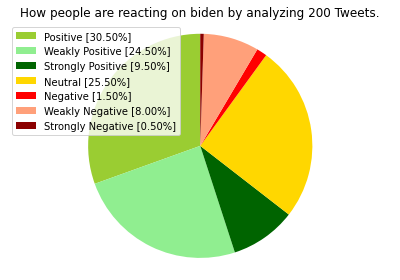

In [19]:
# finding average reaction
polarity = polarity / NoOfTerms

# printing out data
print("How people are reacting on " + searchTerm + " by analyzing " + str(NoOfTerms) + " tweets.")
print()
print("General Report: ")

if (polarity == 0):
    print("Neutral")
elif (polarity > 0 and polarity <= 0.3):
    print("Weakly Positive")
elif (polarity > 0.3 and polarity <= 0.6):
    print("Positive")
    print("\U0001f600")
elif (polarity > 0.6 and polarity <= 1):
    print("Strongly Positive")
elif (polarity > -0.3 and polarity <= 0):
    print("Weakly Negative")
elif (polarity > -0.6 and polarity <= -0.3):
    print("Negative")
elif (polarity > -1 and polarity <= -0.6):
    print("Strongly Negative")

print()
print("Detailed Report: ")
print(str(positive) + "% people thought it was positive")
print(str(wpositive) + "% people thought it was weakly positive")
print(str(spositive) + "% people thought it was strongly positive")
print(str(negative) + "% people thought it was negative")
print(str(wnegative) + "% people thought it was weakly negative")
print(str(snegative) + "% people thought it was strongly negative")
print(str(neutral) + "% people thought it was neutral")

plotPieChart(positive, wpositive, spositive, negative, wnegative, snegative, neutral, searchTerm, NoOfTerms)